# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
import statistics as st
warnings.filterwarnings('ignore')
from sklearn import linear_model 
from sklearn import tree
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов
Данные о клиентах банка:  

- age (возраст);  
- job (сфера занятости);  
- marital (семейное положение);  
- education (уровень образования);  
- default (имеется ли просроченный кредит);  
- housing (имеется ли кредит на жильё);  
- loan (имеется ли кредит на личные нужды);  
- balance (баланс).  

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:  

- contact (тип контакта с клиентом);  
- month (месяц, в котором был последний контакт);  
- day (день, в который был последний контакт);  
- duration (продолжительность контакта в секундах).  

Прочие признаки:  

- campaign (количество контактов с этим клиентом в течение текущей кампании);  
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);  
- previous (количество контактов до текущей кампании)  
- poutcome (результат прошлой маркетинговой кампании).  

Целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# исследуйте данные на предмет пропусков. 
# Где есть пропущенные значения? Сколько их?
# ваш код

df_nan = df.isna().sum().to_frame(name="nans").query("nans>0")["nans"]
print('В признаке', *df_nan.index, 'имеется', *df_nan.values, 'пропусков.')

В признаке balance имеется 25 пропусков.


### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? 
# Возможно, они обозначены каким-то специальным словом?
# ваш код

df_job = list(df['job'].unique())
df_job = ", ".join(df_job)

print(f"В признаке job имеются следующие уникальные значения:\n{df_job}\n\
Очевидно, что словом 'unknown' обозначены пропущенные значения.")

В признаке job имеются следующие уникальные значения:
admin., technician, services, management, retired, blue-collar, unemployed, entrepreneur, housemaid, unknown, self-employed, student
Очевидно, что словом 'unknown' обозначены пропущенные значения.


### Задание 3

In [5]:
# преобразуйте признак balance таким образом, 
# чтобы он корректно считывался, как вещественное число (float)

def to_float(x):
    if x is np.nan:
        return np.nan
    elif str(x)[0] == '0':
        return 0
    else:
        return int(str(x)[:-6].replace(' ', ''))

df['balance'] = df['balance'].apply(to_float)
bal_mean = df['balance'].mean()
print("Среднее значение признака 'balance':", round(bal_mean, 3))
print("Тип признака 'balance' после преобразования:", str(df['balance'].dtype))

Среднее значение признака 'balance': 1529.129
Тип признака 'balance' после преобразования: float64


### Задание 4

In [6]:
# обработайте пропуски в признаки balance, 
# заменив их на медианные значения по данному признаку
# ваш код

df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median()
bal_mean = df['balance'].mean()
print("Среднее значение признака 'balance' после замены \
пропусков на медиану:", round(bal_mean, 3))

Среднее значение признака 'balance' после замены пропусков на медиану: 1526.936


### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, 
# заменив их на модальные значения
# ваш код

df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace(
    'unknown', df['education'].mode()[0])
lst_job = df['job'].to_list()
lst_ed = df['education'].to_list()

from collections import Counter
count_job = Counter(lst_job)
count_ed = Counter(lst_ed)
job_pop = count_job.most_common()[0][0]
ed_pop = count_ed.most_common()[0][0]
print('Наиболее популярная работа:', job_pop)
print('Наиболее популярный уровень образования:', ed_pop)

# Фильтрация по наиболее популярным уровням образования и работы
job_ed_popul = df[(df['job'] == job_pop) & (df['education'] == ed_pop)]

popul_mean = job_ed_popul['balance'].mean()
print('Средний баланс для клиентов с самыми популярными \
уровнями образования и работы:', round(popul_mean, 3))

Наиболее популярная работа: management
Наиболее популярный уровень образования: secondary
Средний баланс для клиентов с самыми популярными уровнями образования и работы: 1598.883


### Задание 6

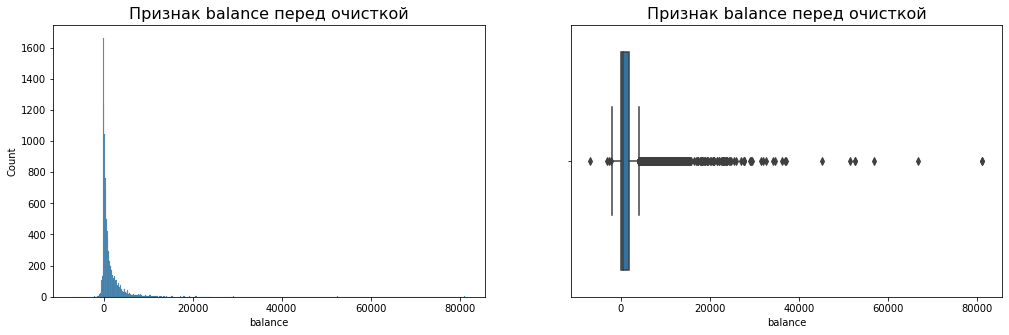

In [8]:
# Диаграммы 'balance' перед очисткой.  
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
histplot = sns.histplot(data=df, x='balance', ax=axes[0])
histplot.set_title("Признак balance перед очисткой", fontsize=16)
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1])
boxplot.set_title("Признак balance перед очисткой", fontsize=16)
fig.show()

In [9]:
# удалите все выбросы для признака balance
# ваш код

# Воспользуемся функцией из учебных материалов.  
def bound_blow_iqr(data, col_data):
    x = data[col_data]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*1.5)
    upper_bound = quartile_3 + (iqr*1.5)
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>=lower_bound) & (x<=upper_bound)]
    return cleaned, lower_bound, upper_bound, outliers

df, lower_bound, upper_bound, outliers = bound_blow_iqr(df, 'balance')
print(f'Нижняя граница выбросов: {round(lower_bound)}')
print(f'Верхняя граница выбросов: {round(upper_bound)}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'После удаления всех выбросов осталось {df.shape[0]} объектов.')

Нижняя граница выбросов: -2241
Верхняя граница выбросов: 4063
Число выбросов по методу Тьюки: 1057
После удаления всех выбросов осталось 10105 объектов.


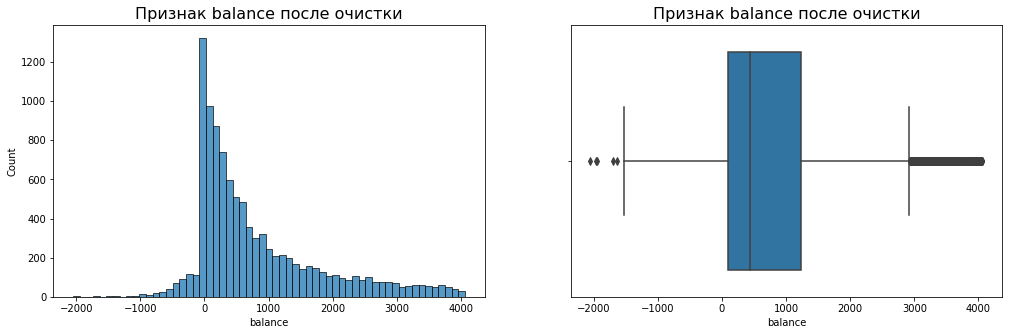

In [10]:
# Диаграммы 'balance' после очистки.  
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
histplot = sns.histplot(data=df, x='balance', ax=axes[0])
histplot.set_title("Признак balance после очистки", fontsize=16)
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1])
boxplot.set_title("Признак balance после очистки", fontsize=16)
fig.show()

## Часть 2:  Разведывательный анализ

### Задание 1

Депозит открыли 4681 клиентов, соответственно, 5424 клиентов депозит не открывали.


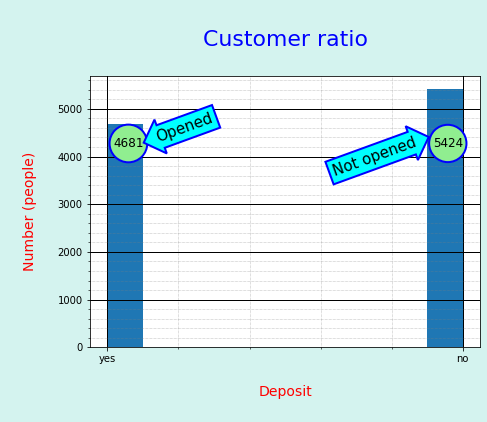

In [11]:
# изучите соотношение классов в ваших данных на предмет 
# несбалансированности, проиллюстрируйте результат
# ваш код

depos_yes= df[df['deposit'] == 'yes'].count()[0]
depos_no= df[df['deposit'] == 'no'].count()[0]
print(f"Депозит открыли {depos_yes} клиентов, соответственно, \
{depos_no} клиентов депозит не открывали.")

# задаём figure, axes, размер, цвет фона.
fig, axes = plt.subplots(figsize=(7, 5), facecolor='#D4F3EF')

# Построение гистограммы соотношения класса клиентов по депозиту
axes.hist(df['deposit'])
axes.set_title('\nCustomer ratio\n', c='b', ha='center', fontsize=22)
axes.set_xlabel('\nDeposit\n', c='r', fontsize=14)
axes.set_ylabel('\nNumber (people)\n', c='r', fontsize=14)
axes.text(0.916, 4200, depos_no, size=12, bbox=dict(
    boxstyle="circle, pad=0.3", fc="lightgreen", ec="b", lw=2))
axes.text(0.016, 4200, depos_yes, size=12, bbox=dict(
    boxstyle="circle, pad=0.3", fc="lightgreen", ec="b", lw=2))
axes.text(0.13, 4300, "Opened", rotation=20, size=15, bbox=dict(
    boxstyle="larrow, pad=0.3",fc="cyan", ec="b", lw=2))
axes.text(0.63, 3600, "Not opened", rotation=20, size=15, bbox=dict(
    boxstyle="rarrow, pad=0.3", fc="cyan", ec="b", lw=2))
axes.grid(which='both', color='k', linewidth=1)
axes.minorticks_on()
axes.grid(which='minor', color='grey', linestyle=':', linewidth=0.5)
axes.set_xticks([0, 1])
plt.show()

### Задание 2

Удобная функция describe() выводит все самые необходимые агрегации описательной статистики. Но, к сожалению, она не выводит такие распространённые меры как мода и медиана. Поэтому воспользуемся библиотекой statistics, с её помощью определим эти необходимые меры и объединим их с DataFrame от describe(). Получим итоговый DataFrame, где помимо прочих мер, будут также отображаться мода и медиана.

In [12]:
#рассчитайте описательные статистики для количественных 
# переменных, проинтерпретируйте результат
#ваш код

num = [
    'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'
    ]
    
def meas(col):
    return [st.median(df[col]), st.mode(df[col])]

des_df = df.describe(exclude='object')

# Подготовка строк (Series) median_ и mode_  
median_ = pd.Series(
    data={'age': meas(num[0])[0], 'balance': meas(num[1])[0],
    'day': meas(num[2])[0], 'duration': meas(num[3])[0],
    'campaign': meas(num[4])[0], 'pdays': meas(num[5])[0],
    'previous': meas(num[6])[0]}, name='median'
    )
mode_= pd.Series(
    data={'age': meas(num[0])[1], 'balance': meas(num[1])[1],
    'day': meas(num[2])[1], 'duration': meas(num[3])[1],
    'campaign': meas(num[4])[1], 'pdays': meas(num[5])[1],
    'previous': meas(num[6])[1]}, name='mode'
    )

# Добавление строк median_ и mode_ к DataFrame от describe().  
des_df = des_df.append(median_, ignore_index=False)
des_df = des_df.append(mode_, ignore_index=False)
des_df

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000
median,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
mode,31.000000,0.000000,18.000000,161.000000,1.000000,-1.000000,0.000000


Мы получили DF с основными описательными статистическими мерами. В столбце pdays имеются отрицательные значения.  

Если посмотреть возраст, то минимальный ─ 18 лет, максимальный ─ 95. Возраст 95 лет настораживает, но что только не случается в наши дни. Стандартное отклонение вполне нормальное 11.73. Также и мода с медианой имеют нормальные, не закритичные, значения.  

А вот где большой разброс, так это в признаке balance. От -2049 до 4063. Соответственно и std большой ─ 994.15. Обращает на себя внимание мода этого признака, равная 0. Много счетов с нулевым балансом?  

В признаке duration (продолжительность контакта сек.) минимум ─ 2 сек, максимум ─ 3881 сек. (больше 1 часа). Явные аномалии и выбросы. И стандартное отклонение также велико ─ 347 сек. Весьма интересно, что мода в этом признаке равна 1 секунде. Чаще всего с клиентами сотрудники банка общаются в течении 1 секунды?  

----------  
Из предварительного анализа описательных статистик количественных переменных можно сделать однозначный вывод о том, что данные необходимо чистить.  

------------
Теперь построим визуализации на эти признаки

Максимальный возраст клиента банка: 95 лет.
Минимальная продолжительность разговора с клиентом банка 2 сек.


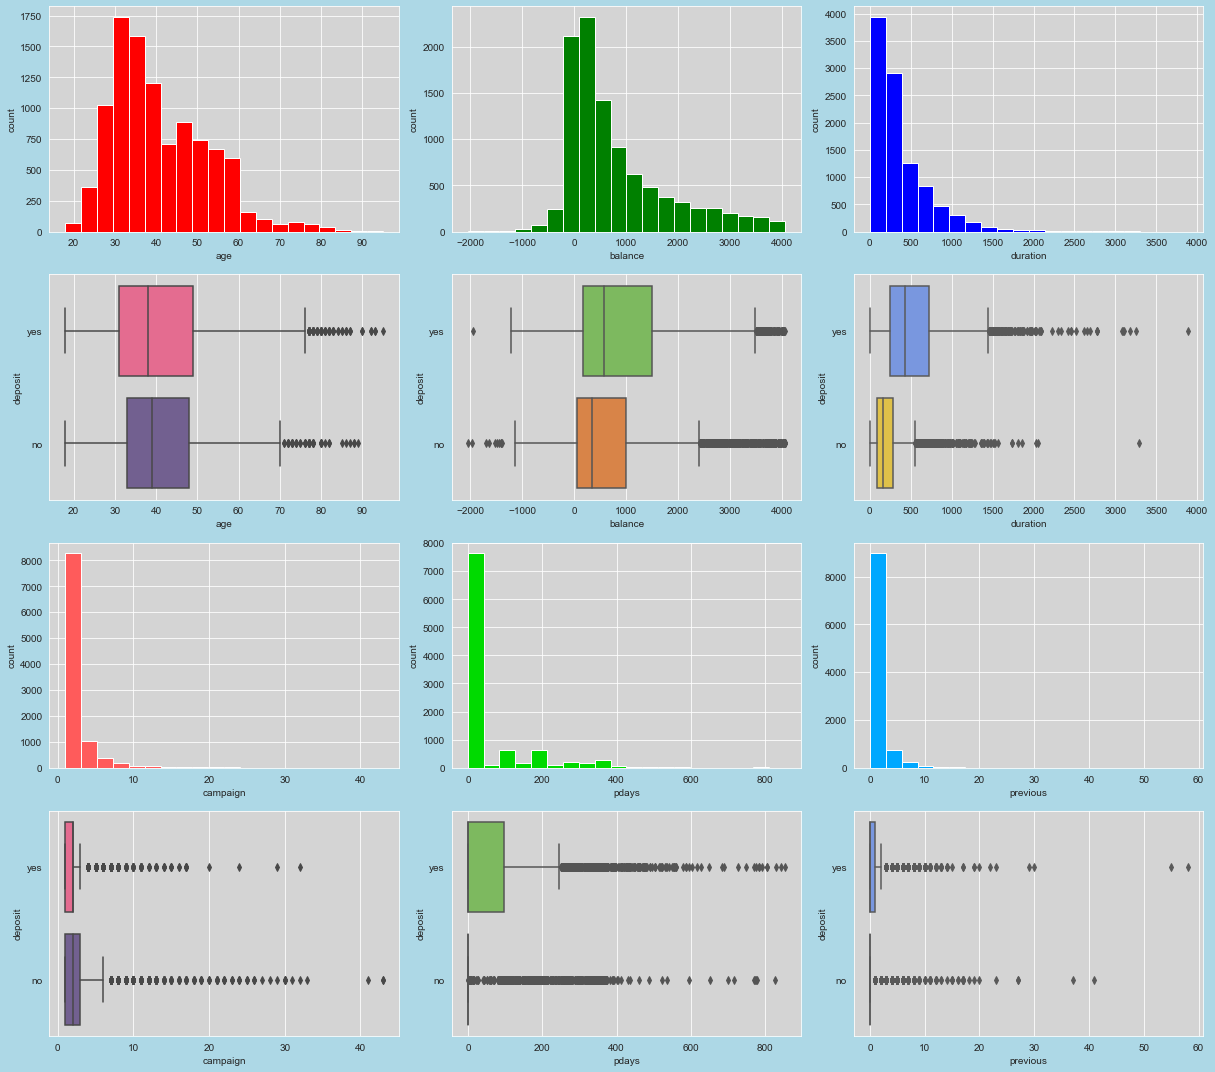

In [13]:
sns.set_style("darkgrid", {"axes.facecolor": ".83"})

# Функции построения гистограмм и ящиков с усами.  
def histo_param (x, y, name, name_y, clr):
    axs[x][y].hist(df[name], bins=20, color=clr)
    axs[x][y].set_xlabel(name)
    axs[x][y].set_ylabel(name_y)
    return None

def box_param(x, y, name, name_y, clr):
    sns.boxplot(data=df, x=name, y=name_y, palette=clr, ax=axs[x,y]) 
    return None

fig, axs = plt.subplots(4, 3, figsize=(17,15), facecolor='lightblue')
histo_param(0, 0, 'age', 'count', 'red')
histo_param(0, 1, 'balance', 'count', 'green')
histo_param(0, 2, 'duration', 'count', 'blue')
box_param(1, 0, 'age', 'deposit', ['#F85888', '#705898'])
box_param(1, 1, 'balance', 'deposit', ['#78C850', '#F08030'])
box_param(1, 2, 'duration', 'deposit', ['#6890F0','#F8D030'])
histo_param(2, 0, 'campaign', 'count', '#FF5B5B')
histo_param(2, 1, 'pdays', 'count', '#00DA00')
histo_param(2, 2, 'previous', 'count', '#00A8FF')
box_param(3, 0, 'campaign', 'deposit', ['#F85888', '#705898'])
box_param(3, 1, 'pdays', 'deposit', ['#78C850', '#F08030'])
box_param(3, 2, 'previous', 'deposit', ['#6890F0','#F8D030'])
plt.tight_layout()
fig.show()

print(f"Максимальный возраст клиента банка: {df['age'].max()} лет.")

# Минимальная продолжительность разговора с клиентом банка.  
print(f"Минимальная продолжительность разговора с клиентом \
банка {df['duration'].min()} сек.")

**Возраст (age).**  
Медиана сдвинута влево из-за больших возрастов, больще 90 лет. На гистограмме видно преобладание возрастов от 27 до 43 лет. Если удалить выбросы по возрастам, то, вероятно, перекос в старший возраст уменьшится, распределение приобретёт более нормальный вид.  

**Баланс (balance).**  
Видны отрицательные выбросы. Классическое логнормальное распределение. Средний баланс около 700-800$.  

**Время контакта (duration).**  
Явные выбросы: контакт среди открывших депозит больше часа, среди тех, кто депозит не открывал ─ около 50 минут. Необходима чистка. Распределение логнормальное.  

**Число контактов (campaing).**  
Большое количество выбросов и у "депозитников", и у "недепозитников".  

**Количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании (pdays).**  
Присутствуют выбросы: от 200 до свыше 800 дней.  

**Количество контактов до текущей кампании (previous).**  
Опять выбросы: число контактов велико, у "депозитников" доходит чуть ли не до 60.  

### Задание 3

Количество месяцев, в которых проводилась маркетинговая компания: 12
Среди клиентов банка представлено следующее количество сфер занятости: 11


,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


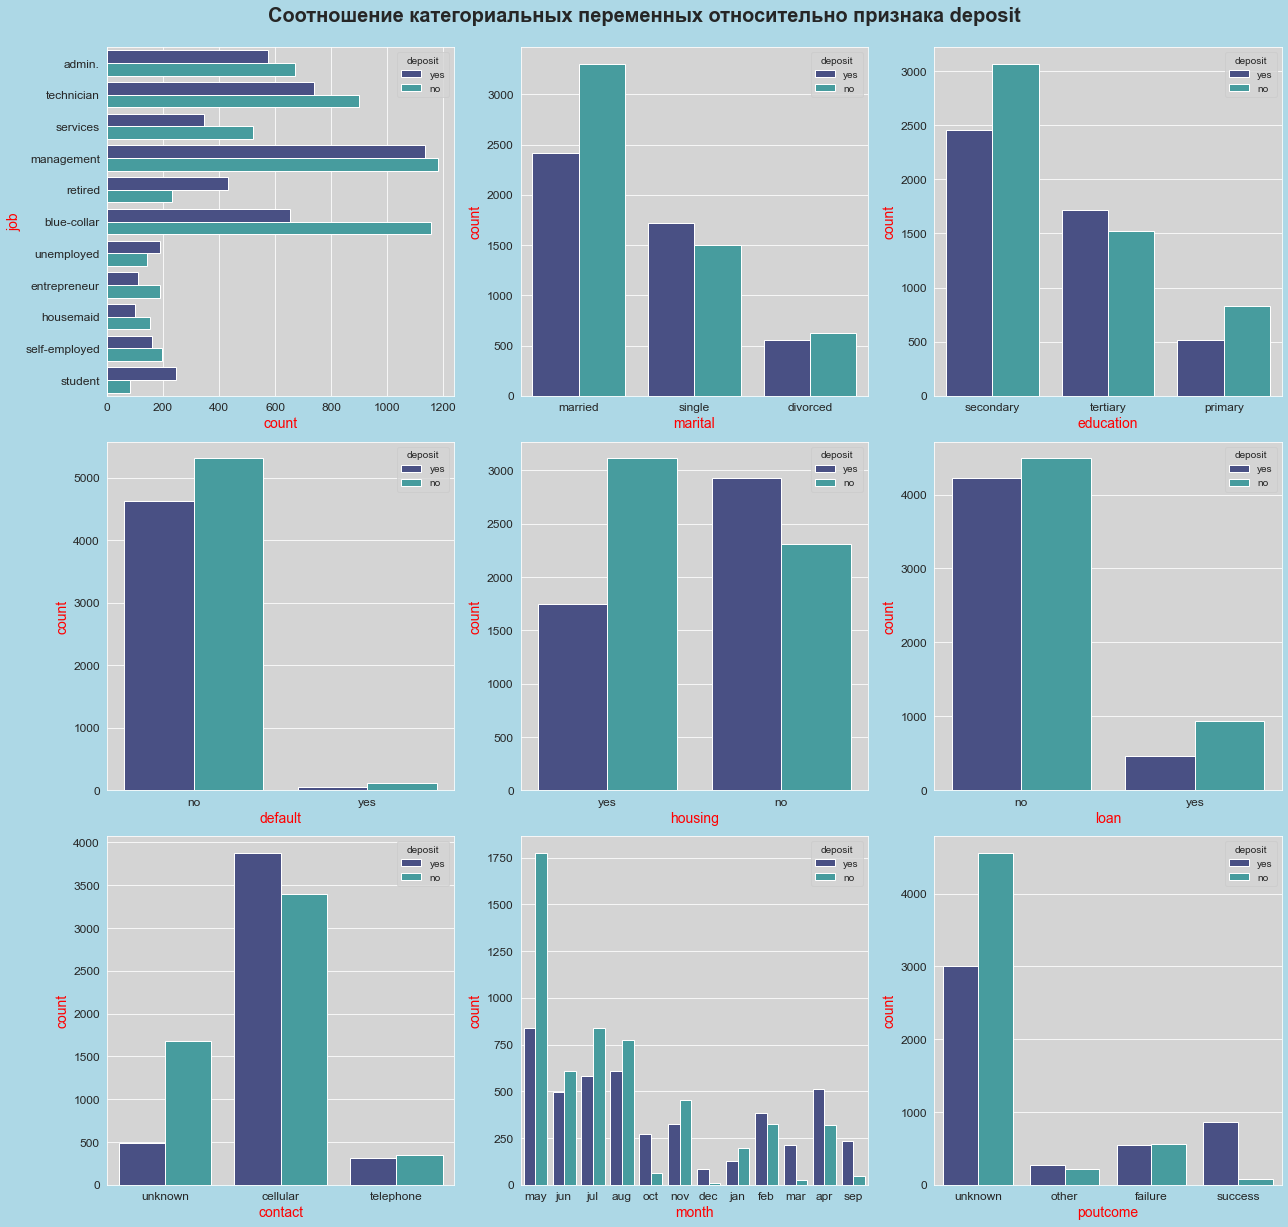

In [14]:
#рассчитайте описательные статистики для категориальных переменных, 
# проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

print("Количество месяцев, в которых проводилась маркетинговая \
компания:", len(df['month'].unique()))
print("Среди клиентов банка представлено следующее количество \
сфер занятости:", len(df['job'].unique()))

# Подготовим DF - удалим признаки object.  
# Чтобы не затронуть основной DF, сделаем его копирование.  
df_categ = df.copy(deep=True)
display(df.describe(include='object'))
df_categ.drop(columns=[
    'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'
    ], axis=1, inplace=True)

# Получение списка данных признака 'deposit'.  
dp_name = df_categ['deposit'].tolist()

# Функция визуализации категориальных данных.  
def count_param(a, b, col):
    col_name = df_categ[col].tolist()
    dfc = pd.DataFrame({col: col_name, 'deposit': dp_name})
    if col == 'job':
        sns.countplot(
            y=col, hue='deposit', data=dfc, palette='mako', ax=ax[a,b])
    else:
        sns.countplot(
            x=col, hue='deposit', data=dfc, palette='mako', ax=ax[a,b])
    return dfc

params = {'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'axes.labelsize': 14,
          'axes.labelcolor': 'red'
          }
plt.rcParams.update(params)
fig, ax = plt.subplots(3, 3, figsize=(18,17), facecolor='lightblue')
plt.suptitle(
    'Соотношение категориальных переменных относительно признака deposit',
    y=1, ha='center', weight='bold', fontsize=20
    )
count_param(0, 0, 'job')
count_param(0, 1, 'marital')
count_param(0, 2, 'education')
count_param(1, 0, 'default')
count_param(1, 1, 'housing')
count_param(1, 2, 'loan')
count_param(2, 0, 'contact')
count_param(2, 1, 'month')
count_param(2, 2, 'poutcome')
plt.tight_layout()
fig.show()

**Сфера занятости (job)**.  
Всего среди клиентов банка представлено 11 сфер занятости. Как ни странно, но рост вкладов по депозитам наблюдается среди пенсионеров (отставников) ─ превышает чуть ли не вдвое "недепозитников" и среди безработных и студентов.  

**Семейное положение (martial)**.  
Женатые (замужние) клиенты преобладают, но если среди них и разведённых спад, то среди одиноких небольшой подъём.  

**Образование (education)**.  
Клиентов банка со средним образованием больше всего.
Однако по всем уровням образования спад, кроме высшего образования. Оно лидирует в открытии депозита, но ненамного.  

**Просроченный кредит (default)**.  
По диаграмме видно, что просрочек по кредиту практически нет у обеих групп. Тем не менее, клиенты без просроченного кредита не спешат открывать депозит.  

**Кредит на жильё (housing)**.  
Закредитованные клиенты депозит не открывают, а у бескредитных, наборот, депозитные счета идут во главе.  

**Кредит на личные нужды (loan)**.  
В обеих группах результат отрицательный ─ клиенты-"недепозитники" преобладают.  

**Тип контакта с клиентом (contact)**.  
При связи по мобильному клиенты спешат открыть депозит, в то время, как при остальных типах контакта ─ результат отрицательный.  

**Месяц, в котором был последний контакт (month)**.  
Богаты на депозитников следующие месяцы:  
- октябрь;  
- декабрь;  
- февраль;  
- март;  
- апрель;  
- сентябрь. 
То есть, осень-зима-весна. Летом и в начале осени роста депозитных счетов не наблюдается. Обращает на себя месяц май. Слишком высок отрицательный результат, вполне возможно, что эти данные не отражают истинного положения вещей.  

**Результаты прошедшей маркетиноговой компании (poutcome)**.  
Прошедшая успешно кампания вызвала бурный рост депозитных счетов.  

-------------  
Резко отрицательный результат наблюдается среди рабочих с почасовой оплатой (синие воротнички), среди ипотечных кредитов. Майская маркетингова компания не радует своим результатом.

### Задание 4

In [15]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в 
# текущей превалирует над количеством неудач.
# ваш код

succ = df.groupby(
    'poutcome')['deposit'].value_counts().unstack().reset_index()
print(f"Название статуса успешной кампании ─ {succ.poutcome[2]}.")

Название статуса успешной кампании ─ success.


### Задание 5

Чаще всего от предложения открыть депозит отказывались в may.


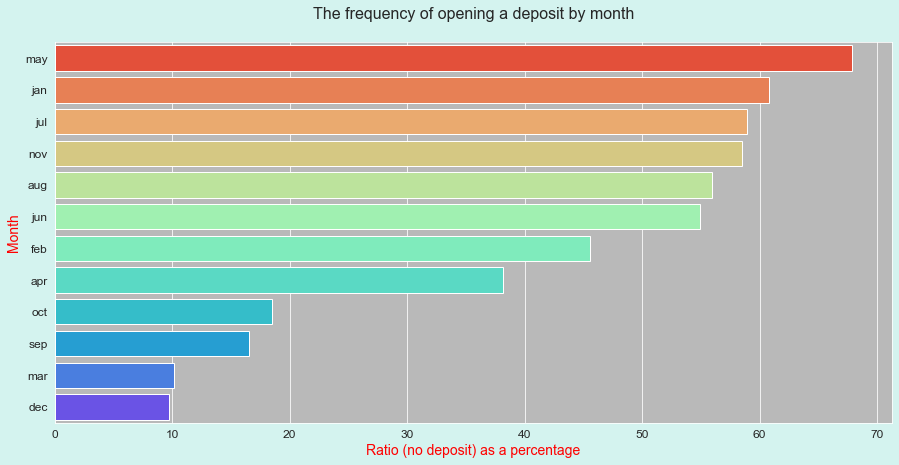

In [16]:
# узнайте, в каком месяце чаще всего отказывались от предложения 
# открыть депозит
# ваш код

succ = df.groupby(
    ['month'])['deposit'].value_counts().unstack().reset_index()
succ['ratio % no'] = 0
succ['ratio % yes'] = 0

for i in range(0, 12):
    succ.iloc[i, 3] = round(
        succ.iloc[i, 1] / (succ.iloc[i, 1] + succ.iloc[i, 2])*100, 2)
    succ.iloc[i, 4] = round(
        succ.iloc[i, 2] / (succ.iloc[i, 1] + succ.iloc[i, 2])*100, 2)

df_s = succ.sort_values(
    'ratio % no', ascending=False).reset_index(drop=True)
succ = succ[
    succ['ratio % no'] == succ['ratio % no'].max()].reset_index()
print(f"Чаще всего от предложения открыть депозит \
отказывались в {succ['month'][0]}.")

# Построение диаграммы соотношения отказов от депозита по месяцам.  
fig = plt.figure(figsize=(15,7),facecolor='#D4F3EF')
ax = fig.add_subplot(facecolor='#B9B9B9')
ax = sns.barplot(data=df_s, x='ratio % no', y='month', palette='rainbow_r')
ax.set_title('The frequency of opening a deposit by month\n', fontsize=16);
ax.set(xlabel='Ratio (no deposit) as a percentage', ylabel='Month')
fig.show()

### Задание 6

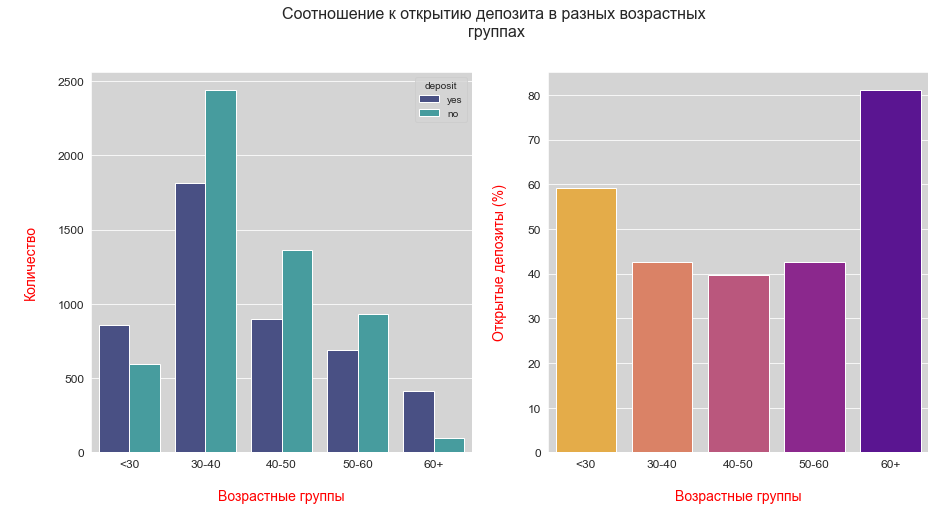

In [17]:
# создайте возрастные группы и определите, в каких группах более 
# склонны открывать депозит, чем отказываться от предложения

# Создаю признак (переменную) для возрастных индикаторов групп 
df['age_group'] = ''

# Заполняю age_group возрастными индикаторми
for x, vol in enumerate(df['age']):
    if vol < 30: 
        df.iloc[x, 17] = '<30'
    elif (vol >= 30) & (vol <= 40):
        df.iloc[x, 17] = '30-40'
    elif (vol >= 40) & (vol <= 50):
        df.iloc[x, 17] = '40-50'
    elif (vol >= 50) & (vol <= 60):
        df.iloc[x, 17] = '50-60'
    if vol > 60: 
        df.iloc[x, 17] = '60+'
        
fig, axs = plt.subplots(1, 2, figsize=(15,7))
plt.suptitle("Соотношение к открытию депозита в разных \
возрастных \nгруппах", fontsize=16, y=1.01, ha='center')
sns.countplot(
    x='age_group', hue='deposit', 
    data=df, palette='mako', ax=axs[0],
    order=['<30', '30-40', '40-50', '50-60', '60+']
    )

axs[0].set_xlabel('\nВозрастные группы\n')
axs[0].set_ylabel('\nКоличество\n')

pivot_tab = (df.groupby('age_group')['deposit'] \
            .value_counts(normalize=True)*100) \
            .unstack().reset_index()
sns.barplot(
    data=pivot_tab, x='age_group', y='yes', 
    order=['<30', '30-40', '40-50', '50-60', '60+'],
    ax=axs[1], palette='plasma_r'
    )

axs[1].set_xlabel('\nВозрастные группы\n')
axs[1].set_ylabel('Открытые депозиты (%)\n')
fig.show()

Из диаграммы видно, что возрастные группы <30 и 60+ ─ это те две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке.

### Задание 7

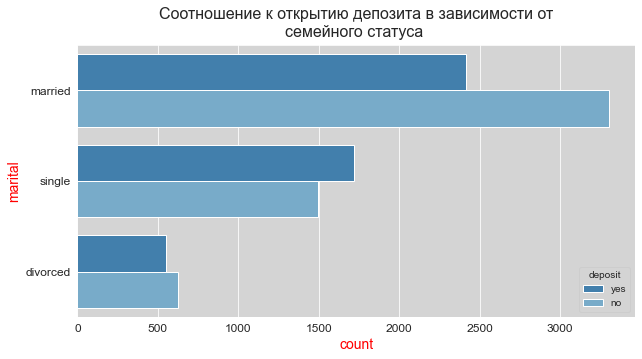

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в 
# зависимости от семейного статуса

fig, ax = plt.subplots(figsize = (10,5))
ax.set_title("Соотношение к открытию депозита в зависимости \
от\nсемейного статуса ", fontsize=16, y=1.01, ha='center')
sns.countplot(y='marital', hue='deposit', data=df, palette='tab20c')
fig.show()


Большинство клиентов банка женатые (замужние). Среди одиноких клиентов преобладает тенденция к открытию депозита. Женатые (замужние) и разведённые в основном отказываются открывать депозит. 

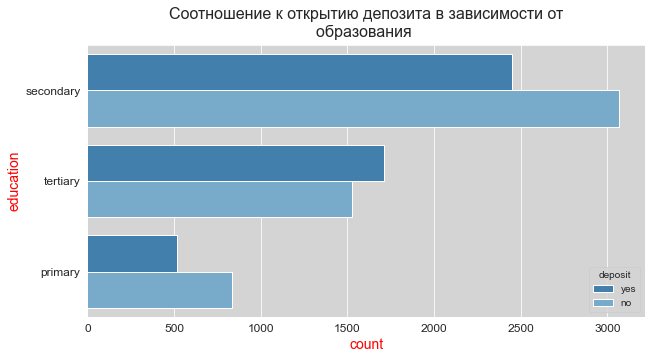

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в 
# зависимости от образования
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title("Соотношение к открытию депозита в зависимости \
от\nобразования ", fontsize=16, y=1.01, ha='center')
sns.countplot(y='education', hue='deposit', data=df, palette='tab20c')
fig.show()

Клиенты со средним образованием составляют большинство. Но они и клиенты с начальным образованием в большинстве своём отказываются открывать депозит. У клиентов с высшим образованием иная точка зрения. Среди них преобладают те, кто открыл депозит.

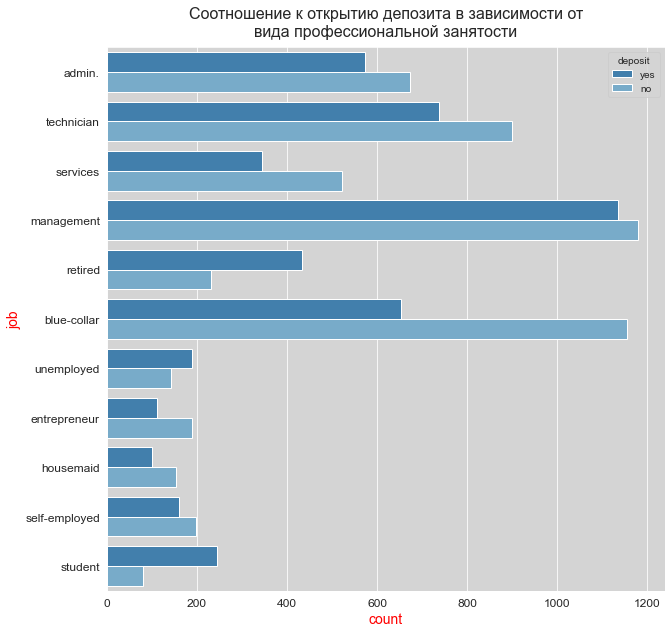

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в 
# зависимости от вида профессиональной занятости
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Соотношение к открытию депозита в зависимости \
от\nвида профессиональной занятости", fontsize=16, y=1.01, ha='center')
sns.countplot(y='job', hue='deposit', data=df, palette='tab20c')
fig.show()

Техники, менеджеры и синие воротнички составляют большинство. Среди пенсионеров, безработных и студентов есть тенденция соглашаться открывать депозит. Среди оставшихся групп сферы занятости тенденция противоположная ─ не открывать депозит. 

In [21]:
print("Наибольшее число клиентов банка занято в сфере", df['job'].mode()[0])
print("Из диаграммы выше видно, что при семейном положении \
'single' есть тенденция открывать депозит.")

Наибольшее число клиентов банка занято в сфере management
Из диаграммы выше видно, что при семейном положении 'single' есть тенденция открывать депозит.


### Задание 8

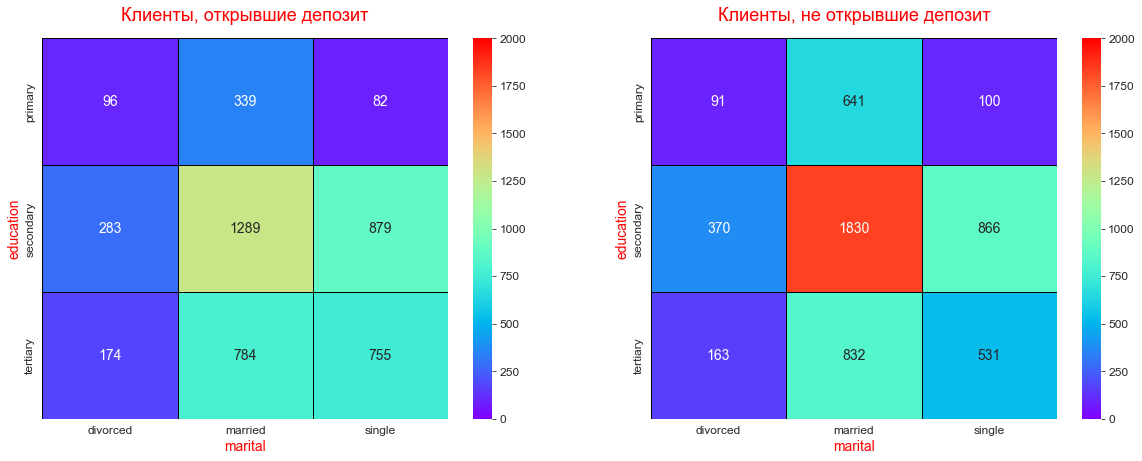

In [22]:
# постройте сводную таблицу, чтобы определить люди с каким образованием 
# и семейным статусом наиболее многочисленны

# Фильтрация данных в DF на открывших и не открывших депозит.  
dep_yes = df[df['deposit']=='yes']
dep_no = df[df['deposit']=='no']

# Группировка, создание сводных таблиц.  
# В ячейках показано количество клиентов в зависимости от 
# семейного положения и уровня образования
open_pivot = dep_yes.groupby(
    ['education', 'marital'])['marital'].count().unstack()
no_open_pivot = dep_no.groupby(
    ['education', 'marital'])['marital'].count().unstack()

# Построение тепловой карты
fig, ax = plt.subplots(1, 2, figsize=(20,7))
ax[0].set_title('Клиенты, открывшие депозит', fontsize=18, color='red', \
    y=1.03, ha='center')
ax[1].set_title('Клиенты, не открывшие депозит', fontsize=18, color='red', \
    y=1.03, ha='center')
sns.heatmap(
    open_pivot, annot=True, annot_kws={"fontsize": 14}, vmin=0, 
    vmax=2000, center=1000, cmap='rainbow', linewidth=1, 
    linecolor='black', fmt='1g', ax=ax[0]
    )
sns.heatmap(
    no_open_pivot, annot=True, annot_kws={"fontsize": 14}, vmin=0, 
    vmax=2000, center=1000, cmap='rainbow', linewidth=1, 
    linecolor='black', fmt='1g', ax=ax[1]
    )
fig.show()

На тепловых картах очень хорошо выделяется их центр. И в открывшей депозит группе, и в не открывшей пересекются одни и те же категории: married и secondary. То есть, в обеих группах преобладают клиенты семейные со средним образованием.

## Часть 3: преобразование данных

### Задание 1

In [23]:
# преобразуйте уровни образования

# Порядковое кодирование признака education
label_enc = preprocessing.LabelEncoder()
df['education'] = label_enc.fit_transform(df['education'])
df['education'].sum()
df['age_group'] = pd.cut(
    df.age, [0,30,40,50,60,9999], 
    labels=['<30', '30-40', '40-50', '50-60', '60+']
    )
label_enc = preprocessing.LabelEncoder()
df['age_group'] = label_enc.fit_transform(df['age_group'])

print(f"Сумма получившихся значений для признака education: \
{df['education'].sum()}")
df


Сумма получившихся значений для признака education: 11995


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,0
11158,39,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,0
11159,32,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,0
11160,43,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,1


### Задание 2

In [24]:
# преобразуйте бинарные переменные в представление из нулей и единиц

# Согласно задания применяем метод apply
# Преобразуем deposit, default, housing, loan
def code(x):
    if x == 'yes': return 1
    if x == 'no': return 0

df['deposit'] = df['deposit'].apply(code)
df['default'] = df['default'].apply(code)
df['housing'] = df['housing'].apply(code)
df['loan'] = df['loan'].apply(code)

print(f"Стандартное отклонение преобразованной в корректный \
вид целевой переменной deposit: {round(st.stdev(df['deposit']), 3)}")
print(f"Сумма средних арифметических default, housing и loan: \
{round(st.mean(df['default'])+st.mean(df['housing'])+st.mean(df['loan']), 3)}")

Стандартное отклонение преобразованной в корректный вид целевой переменной deposit: 0.499
Сумма средних арифметических default, housing и loan: 0.635


### Задание 3

In [25]:
# создайте дамми-переменные

# Создаём дамми-переменные из оставшихся признаков типа object.  
categ = ['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.concat([df, pd.get_dummies(df[categ])], axis=1)

print(f"Не считая целевой переменной в датасете имеется \
{df.shape[1]-1} признаков.")

# Удаляем преобразованные признаки типа object
obj_cols = df.select_dtypes('object').columns
df.drop(columns=obj_cols, inplace=True)
print(f"После удаление признаков типа object осталось \
{df.shape[1]} признаков.")
display(df)

Не считая целевой переменной в датасете имеется 50 признаков.
После удаление признаков типа object осталось 46 признаков.


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


### Задание 4

Корреляция Пирсона не подходит, так как распределение признаков не обязательно нормальное.  
Поэтому линейной взаимосвязи может не быть.  
Из методов корреляции Спирмена и Кендалла выбираю Кендалла как более устойчивой к ошибкам.

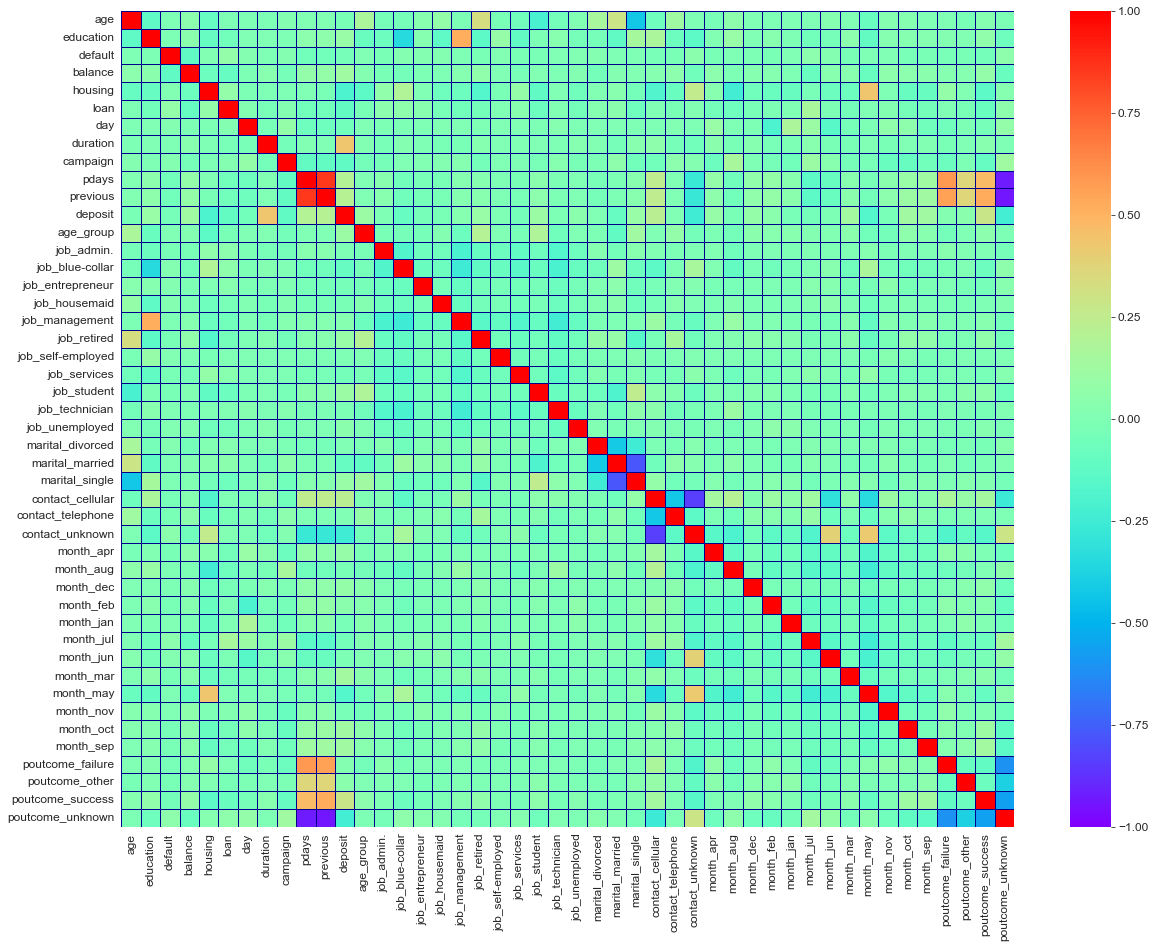

In [26]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

corr_matrix = df.corr(method='kendall')

# Построение тепловой карты.  
fig = plt.figure(figsize=(20,15))

sns.heatmap(corr_matrix, vmin=-1, vmax=1,\
    center=0, cmap='rainbow', linewidth=0.5, linecolor='darkblue', fmt='1g')
fig.show()

Признаки, в наибольшей степени коррелирующие с целевой переменной по убыванию: duration, poutcome_success, contact_cellular.  
Среди признаков мультиколлинеарности выше 0.9 нет.  

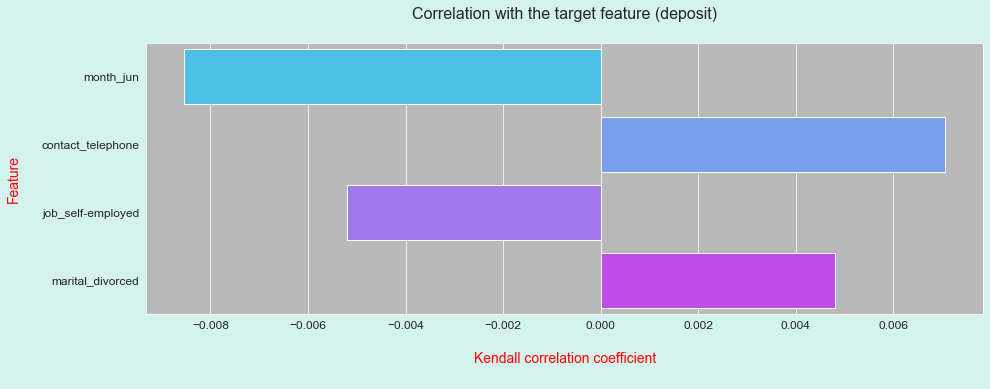

In [27]:
# Столбчатая диаграмма для ранжированных коэффицентов корреляции.  

corr = corr_matrix.copy()

# Удаляем deposit, создаём список ранжированных индексов
corr_df = corr.drop('deposit')
feat_rang =  abs(corr_df['deposit']).sort_values(ascending=False)[-5:-1].index
corr_df.reset_index(inplace=True)

# Построение столбчатой диаграммы.  
fig = plt.figure(figsize=(15,5),facecolor='#D4F3EF')
ax = fig.add_subplot(facecolor='#B9B9B9')
ax = sns.barplot(data=corr_df, y='index', x='deposit', palette='cool', order=feat_rang)
ax.set( xlabel='\nKendall correlation coefficient\n', ylabel='Feature\n')
ax.set_title('Correlation with the target feature (deposit)\n', fontsize=16);
fig.show()

### Задание 5

In [28]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state = 42, test_size = 0.33
    )

In [29]:
# рассчитайте необходимые показатели

print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')
print(f'Среднее значение целевой переменной на тестовой выборке: \
{round(st.mean(y_test), 2)}')

Размер обучающей выборки: 6770
Размер тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 6

In [30]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# Отбираем данные.  
select = SelectKBest(score_func=f_classif, k=15).fit(X_train, y_train)
select_feature=select.get_feature_names_out()
name_lst = ('deposit,' + ",".join(select_feature)).split(',')
print("15 признаков наилучшим образом подходящих для использования в задаче \
(+ deposit):")
display(name_lst)

15 признаков наилучшим образом подходящих для использования в задаче (+ deposit):


['deposit',
 'balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 7

In [31]:

# нормализуйте данные с помощью minmaxsxaler

# Используем только 15 наиболее подходящих признаков.  
X_train = select.transform(X_train)
X_test = select.transform(X_test)

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Среднее арифметическое для первого предиктора: \
{round(X_test[:, 0].mean(), 2)}")

Среднее арифметическое для первого предиктора: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [32]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print("Accuracy на тестовой выборке: {:.2f}". \
    format(log_reg.score(X_test, y_test)))
print("\nОбучающая выборка\n",
      metrics.classification_report(y_train, y_train_pred))
print("Тестовая выборка\n",
      metrics.classification_report(y_test, y_test_pred))



Accuracy на тестовой выборке: 0.81

Обучающая выборка
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Тестовая выборка
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 2

In [33]:
# обучите решающие деревья, настройте максимальную глубину

dtc_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc_tree.fit(X_train, y_train)
y_train_pred = dtc_tree.predict(X_train)
y_test_pred = dtc_tree.predict(X_test)

print('f1_score на обучающем наборе: {:.2f}'. \
    format(metrics.f1_score(y_train, y_train_pred)))
print('recall на обучающем наборе: {:.2f}'. \
    format(metrics.recall_score(y_train, y_train_pred)))
print("accuracy на обучающем наборе: {:.2f}". \
    format(dtc_tree.score(X_train, y_train)))
print("После реализации алгоритма решающих деревьев наблюдается \
переобучение.\n")

print('\nОбучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))


f1_score на обучающем наборе: 1.00
recall на обучающем наборе: 1.00
accuracy на обучающем наборе: 1.00
После реализации алгоритма решающих деревьев наблюдается переобучение.


Обучающая выборка:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



В задании на платформе сказано перебрать различные максимальные глубины деревьев и выбрать оптимальную, при котором *accuracy* будет максимальным, но не будет наблюдаться переобучения, то есть качество обучение на обучающей выборке не будет расти. Для решения задачи был создан цикл for, который выполняет этот перебор значений. 

In [34]:
range_ = range(1, 30)
test_lst = []
for i in range_:
    dtc_tree = tree.DecisionTreeClassifier(
        criterion='entropy', random_state=42, max_depth=i)
    dtc_tree.fit(X_train, y_train)
    y_test_pred = dtc_tree.predict(X_test)
    test_lst.append(metrics.accuracy_score(y_test, y_test_pred))
    
# Максимальное значение accuracy  
# Максимальное значение глубины без переобучения
print('Наилучшие параметры при которых не будет переобучения:\n')
print("─ максимальное значение accuracy:", round(np.max(test_lst), 2))
print("─ максимальная глубина дерева:", np.argmax(test_lst))

Наилучшие параметры при которых не будет переобучения:

─ максимальное значение accuracy: 0.81
─ максимальная глубина дерева: 6


### Задание 3

В заданиие на платформе оптимизации гиперпараметров с помощью *GridSearch* указаны следующие параметры:  

- 'min_samples_split': [2, 5, 7, 10];  
  
- 'max_depth': [3, 5, 7].  
  
Таким образом мы получаем сетку из 4 и 3 параметров, поэтому модель будет обучена 12 раз.

In [35]:
# подберите оптимальные параметры с помощью gridsearch

dtc = tree.DecisionTreeClassifier(
    criterion='entropy', random_state=42)

param_grid = {'min_samples_split': [2, 5, 7, 10], 
              'max_depth': [3,5,7]}

grid_search_tree = GridSearchCV(
    estimator=dtc, 
    param_grid=param_grid,
    scoring='f1', # указываем метрику оценки
    cv=5, 
    n_jobs = -1
)

grid_search_tree.fit(X_train, y_train)
print("Наилучшие значения гиперпараметров: \
{}".format(grid_search_tree.best_params_))

y_train_pred = grid_search_tree.predict(X_train)
y_test_pred = grid_search_tree.predict(X_test)

print("\nС установленными лучшими гиперпараметрами имеем:")
print("\naccuracy на тестовом наборе: \
{:.2f}".format(grid_search_tree.score(X_test, y_test)))
y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: \
{:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}

С установленными лучшими гиперпараметрами имеем:

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80


Accuracy в любых случаях (`критерий ─ Джини или энтропия, метрика оценки ─ f1 или accuracy`) при random_state=42 получается равным 0.80. На платформе, непонятно почему, правильным считается ответ 0.79.   
Гиперпараметры при критерии gini: {'max_depth': 7, 'min_samples_split': 2}  
Гиперпараметры при критерии entropy: {'max_depth': 7, 'min_samples_split': 7}  
Поскольку мы, согласно условия на платформе, ранее установили критерий entropy, то будут использоваться следующие полученные гиперпараметры:  
{'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [36]:
# обучите на ваших данных случайный лес

wood_rand = ensemble.RandomForestClassifier(
    n_estimators=100, criterion='gini', min_samples_leaf=5, 
    max_depth=10, random_state=42)

wood_rand.fit(X_train, y_train)
y_test_pred = wood_rand.predict(X_test)
y_train_pred = wood_rand.predict(X_train)

print('\nОбучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred)))
print('Тестовая выборка:\n')
print(metrics.classification_report(y_test, y_test_pred))

print('f1_score на тестовом наборе: {:.2f}'. \
    format(metrics.f1_score(y_test, y_test_pred)))
print('recall на тестовом наборе: {:.2f}'. \
    format(metrics.recall_score(y_test, y_test_pred)))
print("accuracy на тестовом наборе: {:.2f}". \
    format(wood_rand.score(X_test, y_test)))



Обучающая выборка:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Тестовая выборка:

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.82
recall на тестовом наборе: 0.83
accuracy на тестовом наборе: 0.83


### Задание 2

In [37]:
# используйте для классификации градиентный бустинг и 
# сравните качество со случайным лесом

boost_gr = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5,
    max_depth=5, random_state=42)

boost_gr.fit(X_train, y_train)
y_test_pred = boost_gr.predict(X_test)
y_train_pred = boost_gr.predict(X_train)

print('\nОбучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred)))
print('Тестовая выборка:\n')
print(metrics.classification_report(y_test, y_test_pred))

print('f1_score на тестовом наборе: {:.2f}'. \
    format(metrics.f1_score(y_test, y_test_pred)))
print('recall на тестовом наборе: {:.2f}'. \
    format(metrics.recall_score(y_test, y_test_pred)))
print("accuracy на тестовом наборе: {:.2f}". \
    format(wood_rand.score(X_test, y_test)))


Обучающая выборка:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Тестовая выборка:

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.82
recall на тестовом наборе: 0.83
accuracy на тестовом наборе: 0.83


Между полученными значениями тестового набора градиентного бустинга и случайного леса разницы нет.  
Обе модели дают одинаковое качество прогноза:  
Accuracy ─ 0.83 и 0.83  
Recall ─ 0.83 и 0.83  
F1-score ─ 0.82 и 0.82

### Задание3

In [38]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# Заново определяем модели с наилучшими и заданными параметрами.  
dtc_tree = tree.DecisionTreeClassifier(
    criterion='entropy', max_depth=7, min_samples_split=7, random_state=42)
log_reg = linear_model.LogisticRegression(
    solver='sag', max_iter=1000, random_state=42)
boost_gr = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=5, 
    max_depth=5, random_state=42)

estimators = [
    ('dtc_tree', dtc_tree),
    ('log_reg', log_reg),
    ('boost_gr', boost_gr)
    ]

# Выстраиваем ансамбль из моделей.  
stacked = ensemble.StackingClassifier(estimators=estimators)
stacked.fit(X_train, y_train)

y_test_pred = stacked.predict(X_test)
y_train_pred = stacked.predict(X_train)

print('\nОбучающая выборка:\n{}'.format(
    metrics.classification_report(y_train, y_train_pred)))
print('Тестовая выборка:\n{}'.format(
    metrics.classification_report(y_test, y_test_pred)))



Обучающая выборка:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 4

,feature,important
0,duration,0.507106
1,poutcome_success,0.114958
2,contact_unknown,0.072582
3,balance,0.057952
4,pdays,0.055077
5,housing,0.047725
6,age_group,0.039902
7,month_mar,0.027819
8,month_oct,0.019880
9,month_may,0.015214


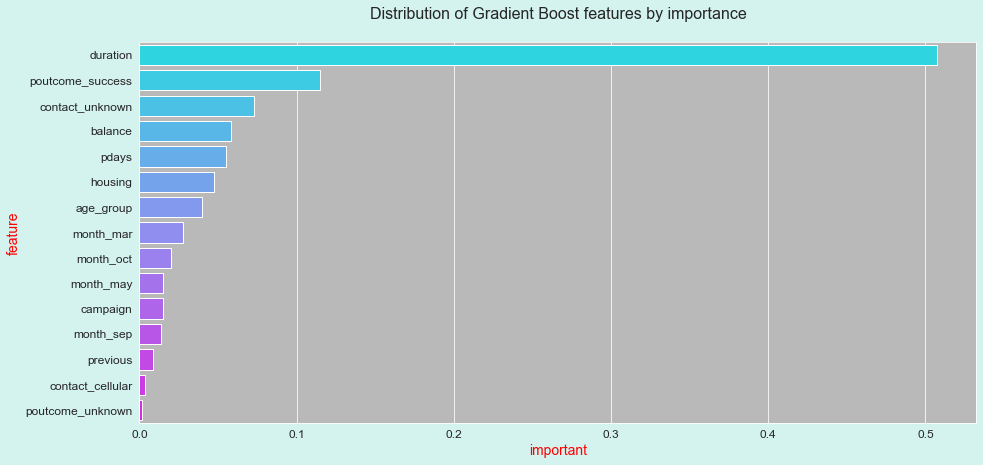

In [39]:
# оцените, какие признаки демонстрируют наибольшую  важность 
# в модели градиентного бустинга

# Поскольку модель boost_gr была переопределена, то обучаем её заново.
boost_gr.fit(X_train, y_train)

# Построение DF с избранными признаками и их важностью
imp_num = list(boost_gr.feature_importances_)
dict = {'feature': select_feature, 'important': imp_num}
dt_ft = pd.DataFrame(dict).sort_values(
    'important', ascending=False).reset_index(drop=True)
display(dt_ft)

# Построение диаграммы важности признаков в модели градиентного бустинга
fig = plt.figure(figsize=(15,7),facecolor='#D4F3EF')
ax = fig.add_subplot(facecolor='#B9B9B9')
ax = sns.barplot(data=dt_ft, x='important', y='feature', palette='cool')
ax.set_title(
    'Distribution of Gradient Boost features by importance\n',
    fontsize=16
    )
fig.show()

На диаграмме видно, что самый важный признак ─ duration. Затем, по убывающей: poutcome_success, contact_unknown, balance и так далее.  
Первые три признака в наибольшей степени коррелируют с целевой переменной и поэтому имеют высокую важность.

### Задание 5

In [40]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
        )

    # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    return score

study = optuna.create_study(
    study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

# выводим результаты по обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2022-08-16 12:23:57,897] A new study created in memory with name: RandomForestClassifier
[I 2022-08-16 12:23:58,742] Trial 0 finished with value: 0.8932979221996562 and parameters: {'n_estimators': 197, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8932979221996562.
[I 2022-08-16 12:23:59,216] Trial 1 finished with value: 0.8929185555729248 and parameters: {'n_estimators': 110, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8932979221996562.
[I 2022-08-16 12:23:59,954] Trial 2 finished with value: 0.8926447574334898 and parameters: {'n_estimators': 171, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8932979221996562.
[I 2022-08-16 12:24:00,420] Trial 3 finished with value: 0.9142318567389255 and parameters: {'n_estimators': 102, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9142318567389255.
[I 2022-08-16 12:24:01,039] Trial 4 finished with value: 0.8539255552080075 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 140, 'max_depth': 25, 'min_samples_leaf': 2}


In [41]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"accuracy: тестовый набор   ⟶ {model.score(X_test, y_test):.2f}")
print(f"accuracy: обучающий набор  ⟶ {model.score(X_train, y_train):.2f}")
print(f'f1_score: тестовый набор:  ⟶ \
{metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'f1_score: обучающий набор: ⟶ \
{metrics.f1_score(y_train, y_train_pred):.2f}')
print('\nТестовая выборка:\n{}'.format(
metrics.classification_report(y_test, y_test_pred)))
print('\nОбучающая выборка:\n{}'.format(
metrics.classification_report(y_train, y_train_pred)))

accuracy: тестовый набор   ⟶ 0.83
accuracy: обучающий набор  ⟶ 0.93
f1_score: тестовый набор:  ⟶ 0.82
f1_score: обучающий набор: ⟶ 0.92

Тестовая выборка:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335


Обучающая выборка:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3634
           1       0.91      0.94      0.92      3136

    accuracy                           0.93      6770
   macro avg       0.93      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770



Если сравнить полученный результат optuna с предыдущими моделями, то значения улучшились на небольшую величину.  
Подвели стекинг и решающие деревья. На их результатах результаты optuna выглядят получше, но незначительно.  

### **Что сделано**
Выполнена предобработка, исследованы данные, проведён разведывательный анализ.  
Найдены закономерности позволяющие выявить факторы, являющимися решающими для оформления депозита.  
Построены диаграммы с их описанием и выводами. Созданы и проанализированы описательные статистические меры с графиками и выводами.  
Отобраны 15 наиболее значимых признаков, построены тепловые карты корреляций.  
Построены и обучены модели логистической регрессии и решающих деревьев.  
Построены модели случайного леса, градиентного бустинга.  
Выполнен поиск и оптимизация наилучших гиперпараметров.  
